# Assignment Day 4

## Team members:
- Samuel Nebgen s6sanebg@uni-bonn.de
- Muhammad Humza Arain s27marai@uni-bonn.de
- Julian Meigen s82jmeig@uni-bonn.de

## 11.09.2025

Contributions were made by all team members in around the same amount, either based on discussions or coding.

# Anomaly Detection in ECG data

This notebook provides tasks to identify anomalies in an ECG data set. Download the dataset from the lab google drive.

Required Python packages: pandas, numpy, matplotlib, pytorch

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


## Task 1: Load an visualize the data

Download the csv from the link provided above and load it into a pandas dataframe. Visualize the data of normal (label 1) vs abnormal (label 0) ECG signals. 

What are the differences for both? Visualize an average normal and abnormal ECG (with standart derivations).

In [2]:
dataframe = pd.read_csv(
    "http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv", header=None
)
raw_data = dataframe.values

In [3]:
dataframe.shape

(4998, 141)

In [4]:
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [5]:
normal_data: pd.DataFrame = dataframe[dataframe[140]==1]
normal_data.shape

(2919, 141)

In [6]:
anormal_data: pd.DataFrame = dataframe[dataframe[140]==0]
anormal_data.shape

(2079, 141)

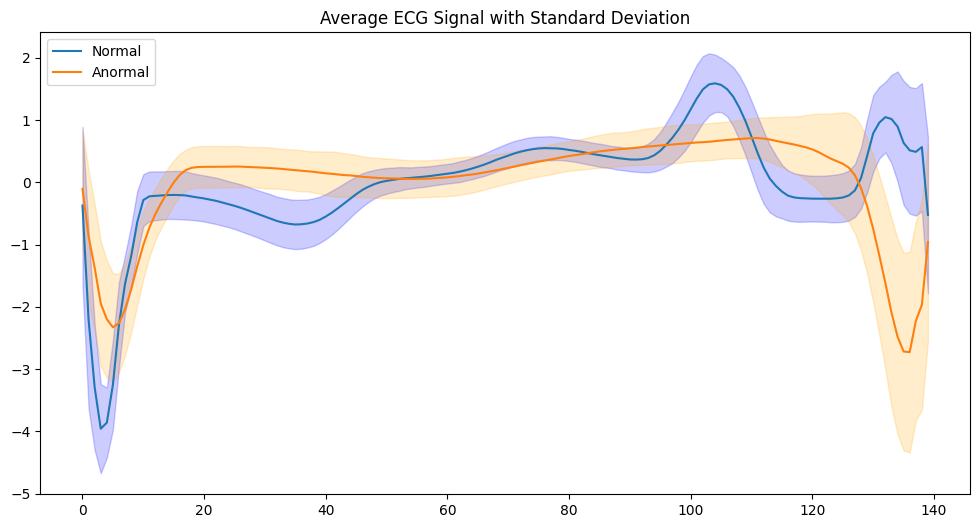

In [7]:
average_normal = normal_data[:-1].mean(axis=0)
average_anormal = anormal_data[:-1].mean(axis=0)

std_normal = normal_data[:-1].std(axis=0)
std_anormal = anormal_data[:-1].std(axis=0)

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(average_normal[:-1], label="Normal")
plt.plot(average_anormal[:-1], label="Anormal")
plt.fill_between(x=range(len(average_normal[:-1])),
                y1=average_normal[:-1]-std_normal[:-1],
                y2=average_normal[:-1]+std_normal[:-1],
                color='blue', alpha=0.2)

plt.fill_between(x=range(len(average_anormal[:-1])),
                y1=average_anormal[:-1]-std_anormal[:-1],
                y2=average_anormal[:-1]+std_anormal[:-1],
                color='orange', alpha=0.2)
plt.title("Average ECG Signal with Standard Deviation")
plt.legend()
plt.show()

In the abnormal data, we can see a large drop in the signal in the end, which is not present in the normal data. Instead, the normal data shows two peaks that do not exist in that form in the abnormal data. Both signals are relatively flat between time point 20 and 100. At the beginning of the signal, both signals show a drop, but the drop in the normal data is more pronounced.

## Task 2: Train a Autoencoder for normal (training data)

Split your data into a (stratified) 80/20 split. Use the normal records of your train data to fit an Autoencoder model. You may use Optuna to find the optimal parametrization of your model.

Visulaize the training/test loss of your model.


In [8]:
import optuna
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

c:\Users\samue\Documents\Life Science Informatics\Semester 2\Machine Learning hands on\ML-handson\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocess Data

In [9]:
y = raw_data[:, -1]
X = raw_data[:, :-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42934, stratify=y)

print(f'Mean of training labels: {train_labels.mean()}, mean of test labels: {test_labels.mean()}')

Mean of training labels: 0.5840420210105053, mean of test labels: 0.584


In [10]:
# For Task 3 we normalize the training data and use the scaler for test data as well
scaler_all = MinMaxScaler()
train_data = scaler_all.fit_transform(train_data)
test_data = scaler_all.transform(test_data)

In [11]:
# For Task 2 we only need the normal data in the training set
train_data_norm = train_data[train_labels == 1]

## Load Data in Dataset and DataLoader

In [12]:
from torch.utils.data import Dataset, DataLoader

In [13]:
class ECGDataset(Dataset):
    def __init__(self, data):
        self.data = torch.from_numpy(data).float()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

## Autoencoder model

In [ ]:
class AE(nn.Module):
    def __init__(self, input_dim=139):
        super(AE, self).__init__()
        # Define the architecture
        # The Encoder part has to compress the input data (139) to a latent space representation (16)
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
        )
        # The Decoder part has to reconstruct the input data (139) from the latent space representation (16)
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid(),  # Use Sigmoid to ensure output is between 0 and 1
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out

## Train AE Model

In [15]:
# Load Data (only normal data for training)
train_dataset = ECGDataset(train_data_norm)
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load Model
input_dim = train_dataset.data.shape[1]
ae_model = AE(input_dim=input_dim)

In [16]:
# Add Loss and Optimizer
loss = nn.L1Loss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

In [17]:
EPOCHS = 200
training_losses = []
for epoch in range(EPOCHS):
    ae_model.train()
    total_loss = 0
    for x in train_data_loader:
        optimizer.zero_grad()
        reconstructed = ae_model(x)
        l = loss(reconstructed, x)
        l.backward()
        optimizer.step()
        total_loss += l.item() * x.size(0)
    total_loss /= len(train_data_loader.dataset)
    training_losses.append(total_loss)

    #print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_data_loader)}")

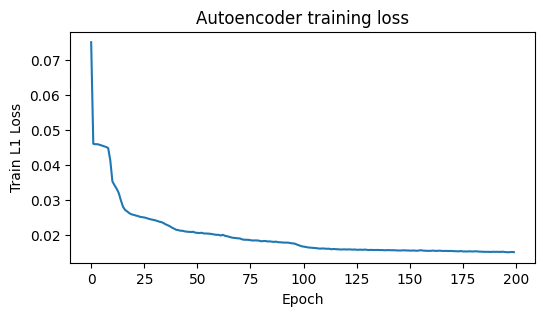

In [18]:
# Plot training loss
plt.figure(figsize=(6,3))
plt.plot(training_losses)
plt.xlabel("Epoch"); plt.ylabel("Train L1 Loss"); plt.title("Autoencoder training loss")
plt.show()

## Evaluate Model

In [19]:
# Load train data for normal and abnormal
train_dataset_norm = ECGDataset(train_data_norm)
train_dataset_anorm = ECGDataset(train_data[train_labels == 0])

In [20]:
ae_model.eval()

err_normal = torch.mean(torch.abs(ae_model(train_dataset.data) - train_dataset.data), dim=1)  # mean across features
err_abnormal = torch.mean(torch.abs(ae_model(train_dataset_anorm.data) - train_dataset_anorm.data), dim=1)  # mean across features

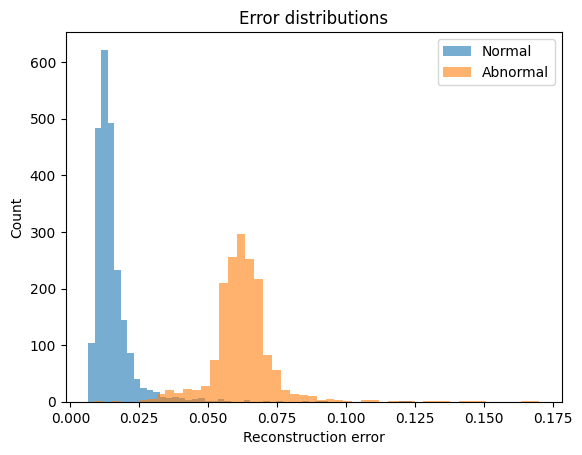

In [21]:
plt.hist(err_normal.detach().numpy(), bins=50, alpha=0.6, label='Normal')
plt.hist(err_abnormal.detach().numpy(), bins=50, alpha=0.6, label='Abnormal')
plt.xlabel("Reconstruction error"); plt.ylabel("Count"); plt.legend(); plt.title("Error distributions")
plt.show()

## Task 3: Treshold your test data & evaluate your model

For any single normal and abnormal test data point, plot the time series, the decoded autoencoder reconstruction and the error as the area between these 2 plots. Compute the absolute error as the absolute of the integral of both graphs.

Plot a histogram of the training/test loss and - based on your findings - generate a treshold to differentiate between normal/anormal test data samples. Based on your predictions, report the performance of your model. 




In [22]:
# load test data for normal and abnormal

test_dataset_norm = ECGDataset(test_data[test_labels == 1])
test_dataset_anorm = ECGDataset(test_data[test_labels == 0])
print(len(test_data))

1000


In [23]:
first_norm = test_dataset_norm[0]
first_norm_hat = ae_model(first_norm).detach()

first_anorm = test_dataset_anorm[0]
first_anorm_hat = ae_model(first_anorm).detach()

Text(0.5, 1.0, 'First normal test sample and its reconstruction')

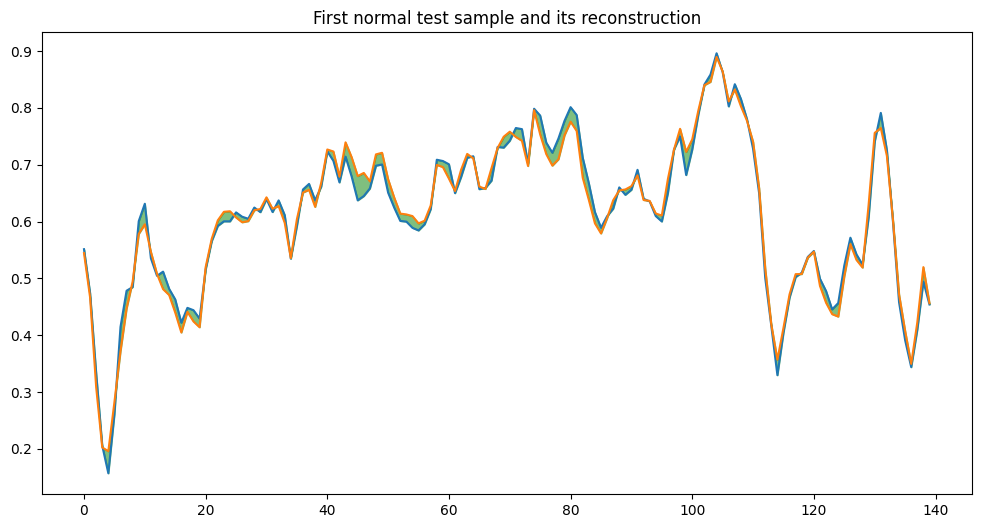

In [24]:
# Plot first Column of test normal and abnormal data

plt.figure(figsize=(12, 6))

plt.plot(first_norm, label='original')
plt.plot(first_norm_hat, label='reconstructed')
plt.fill_between(x=range(len(first_norm)),
                 y1=first_norm,
                 y2=first_norm_hat,
                 color='green', alpha=0.5)
plt.title("First normal test sample and its reconstruction")

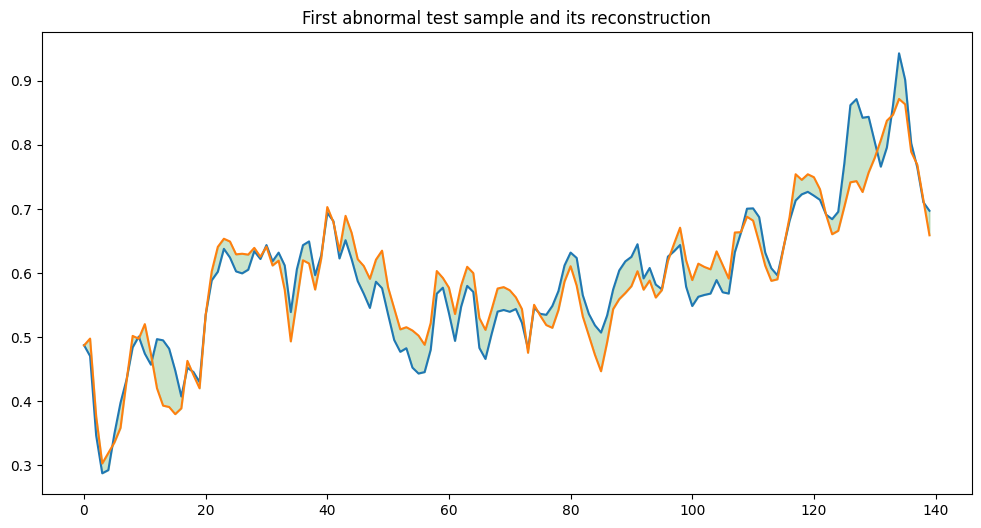

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(first_anorm, label='original')
plt.plot(first_anorm_hat, label='reconstructed')
plt.fill_between(x=range(len(first_anorm)),
                 y1=first_anorm,
                 y2=first_anorm_hat,
                 color='green', alpha=0.2)
plt.title("First abnormal test sample and its reconstruction")
plt.show()

In [26]:
normal_reconstruction_error = torch.sum(torch.abs(first_norm - first_norm_hat))
abnormal_reconstruction_error = torch.sum(torch.abs(first_anorm - first_anorm_hat))

print(f"Absolute error of first normal test sample: {normal_reconstruction_error}")
print(f"Absolute error of first abnormal test sample: {abnormal_reconstruction_error}")

Absolute error of first normal test sample: 1.9343961477279663
Absolute error of first abnormal test sample: 4.417655944824219


## Normal vs Abnormal Classification

Based on a purely visual inspection of the graph from task 2, we set the threshold to 0.03. If a test sample has a reconstruction error above this, we will classify it as abnormal. 

In [27]:
recon_error_norm = torch.mean(torch.abs(ae_model(test_dataset_norm.data) - test_dataset_norm.data), dim=1)  # mean across features
recon_error_anorm = torch.mean(torch.abs(ae_model(test_dataset_anorm.data) - test_dataset_anorm.data), dim=1)  # mean across features

number_false_norm = torch.sum(recon_error_norm > 0.03)
number_false_anorm = torch.sum(recon_error_anorm <= 0.03)
print(f'Out of {len(test_data)}, {number_false_norm + number_false_anorm} were misclassified. For normal {number_false_norm}, for abnormal {number_false_anorm}. The overall accuracy is {(len(test_data)-(number_false_norm+ number_false_anorm))/len(test_data)*100:.2f} %. ')

Out of 1000, 31 were misclassified. For normal 29, for abnormal 2. The overall accuracy is 96.90 %. 


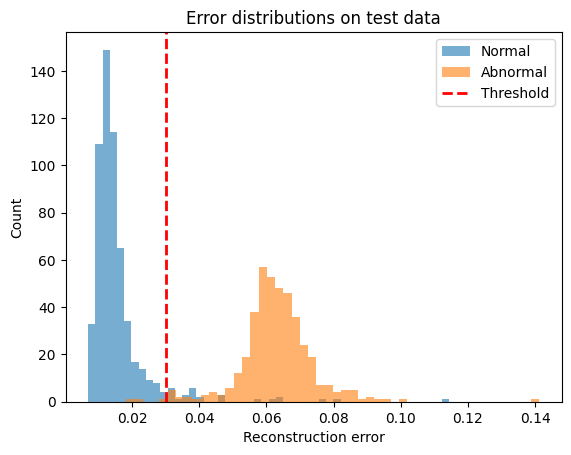

In [28]:
plt.hist(recon_error_norm.detach().numpy(), bins=50, alpha=0.6, label='Normal')
plt.hist(recon_error_anorm.detach().numpy(), bins=50, alpha=0.6, label='Abnormal')
plt.axvline(x=0.03, color='red', linestyle='--', linewidth=2, label='Threshold')

plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.legend()
plt.title("Error distributions on test data")
plt.show()